
# **Web Scraping Class Central dengan Selenium**
---
Pada bagian ini, akan dilakukan web scraping dari situs [Class Central](https://www.classcentral.com/subject/cs) menggunakan **Selenium**.

Tujuan scraping ini adalah untuk mengambil data kursus seperti judul, provider, rating, bahasa, ketersediaan sertifikat, dan status gratis/berbayar.


In [ ]:
# Install semua library yang dibutuhkan

!pip install requests
!pip install selenium
!pip install -q google-colab-selenium
!pip install nltk
!pip install selenium webdriver-manager pandas

!apt-get update
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || apt-get install -f -y

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,268 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,159 kB]
Get:14 http://security.ubuntu.

In [ ]:
import requests
import selenium
import nltk
import random
import time
import pandas as pd
import logging
import string
import json
print("All libraries installed successfully!")

All libraries installed successfully!


# **1. Data Collection**

Install library terkait dan menyiapkan ChromeDriver di Google Colab.

Karena Colab berjalan di server dan bukan di komputer lokal, kita perlu menjalankan Chrome dalam mode headless (tanpa tampilan GUI). Kita juga menggunakan `webdriver-manager` untuk mengelola ChromeDriver secara otomatis.


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager

import copy
import google_colab_selenium as gs

In [ ]:
# Menyiapkan konfigurasi logging untuk memantau proses scraping
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
def setup():

  # Fungsi untuk menyiapkan dan mengembalikan WebDriver (Chrome) di Google Colab.
  # Menggunakan opsi headless dan beberapa flags tambahan agar dapat berjalan stabil.

  logging.info("Menyiapkan WebDriver untuk lingkungan Google Colab...")
  chrome_options = Options()
  chrome_options.add_argument("--headless")  # Menjalankan Chrome tanpa GUI
  chrome_options.add_argument("--no-sandbox")
  chrome_options.add_argument("--disable-dev-shm-usage")
  chrome_options.add_argument("--window-size=1920,1080")
  chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

  # Inisialisasi WebDriver menggunakan ChromeDriverManager
  driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
  logging.info("WebDriver berhasil disiapkan.")
  return driver

## Scraping Data Class Central

Mengambil data dari 100 halaman di situs Class Central. Untuk setiap kursus, kita ambil informasi:
- Judul kursus
- Kategori Kursus
- Provider/platform
- Bahasa
- Sertifikat (tersedia/tidak)
- Rating rata-rata
- Status (gratis atau tidak)
- Jumlah ulasan
- Durasi Kursus
- Overview
- Link ke kursus



---



Menggunakan struktur HTML dan atribut `data-track-props` untuk mengekstrak informasi tersebut.


In [ ]:
def scrape_classcentral(driver, urls_to_scrape):

    # Melakukan scraping dari halaman-halaman Class Central berdasarkan URL dasar.

    all_courses_data = []
    for subject, base_url in urls_to_scrape.items():
      logging.info(f"===== Memulai scraping untuk subjek: {subject.upper()} =====")

      for page in range(1, 101):  # Halaman 1 sampai 100
            url = f"{base_url}?page={page}"
            logging.info(f"Scraping halaman {page}: {url}")
            driver.get(url)
            time.sleep(3)  # Jeda untuk memberi waktu halaman loading

            # Cari semua elemen yang merupakan nama kursus
            course_cards = driver.find_elements(By.CSS_SELECTOR, 'li.course-list-course')
            logging.info(f"Halaman {page}: ditemukan {len(course_cards)} kursus.")

            for card in course_cards:
                try:
                    # Cari judul di dalam 'kartu' kursus
                    title_elem = card.find_element(By.CSS_SELECTOR, 'a.color-charcoal.course-name')
                    # Ambil teks judul dan link
                    title = title_elem.text.strip()
                    link = title_elem.get_attribute('href')

                    # Ambil atribut JSON tersembunyi untuk informasi tambahan
                    data_props_raw = title_elem.get_attribute('data-track-props')
                    data_props = json.loads(data_props_raw)

                    provider = data_props.get("course_provider", "Unknown")

                    # Certificate & Price Formatting
                    certificate = "Certificate Available" if data_props.get("course_certificate", False) else "No Certificate"

                    language = data_props.get("course_language", "N/A")
                    avg_rating = round(data_props.get("course_avg_rating", 0.0), 1)

                    is_free = data_props.get("course_is_free", False)
                    price_type = "Free" if is_free else "Paid"

                    overview_elem = card.find_element(By.CSS_SELECTOR, 'a.color-charcoal.block.hover-no-underline.break-word')
                    course_overview = overview_elem.text.strip() if overview_elem else ""

                    # Ambil container untuk durasi (parent element dua tingkat ke atas)
                    try:
                        # Kita cari elemen durasi di dalam 'card' yang sudah kita temukan
                        duration_elem = card.find_element(By.CSS_SELECTOR, 'span[aria-label="Workload and duration"]')
                        duration = duration_elem.text.strip()
                    except:
                        duration = "N/A" # Fallback jika tidak ditemukan

                    try:
                        # Coba ambil teks ulasan
                        reviews = title_elem.find_element(By.XPATH, '../..').find_element(By.CSS_SELECTOR, 'span.color-gray').text.strip()
                    except:
                        reviews = "0 reviews"

                    # Simpan data ke list
                    all_courses_data.append({
                        'title': title,
                        'category': subject,
                        'provider': provider,
                        'language': language,
                        'certificate': certificate,
                        'avg_rating': avg_rating,
                        'price_type': price_type,
                        'reviews': reviews,
                        'duration': duration,
                        'overview': course_overview,
                        'link': f"https://www.classcentral.com{link}"
                    })

                except Exception as e:
                    logging.warning(f"Error saat membaca 1 kursus di halaman {page}: {e}")
                    continue

    # Konversi hasil scraping ke DataFrame
    return pd.DataFrame(all_courses_data)


In [ ]:
# Inisialisasi WebDriver
driver = setup()

In [ ]:
driver = None
try:
    driver = setup()

    target_urls = {
        "Data Science": "https://www.classcentral.com/subject/data-science",
        "Machine Learning": "https://www.classcentral.com/subject/machine-learning",
        "Data Analysis": "https://www.classcentral.com/subject/data-analysis",
        "Data Engineering": "https://www.classcentral.com/subject/data-engineering",
        "Computer Science": "https://www.classcentral.com/subject/cs"
    }

    scraped_data = scrape_classcentral(driver, target_urls)

    if not scraped_data.empty:
        scraped_data.drop_duplicates(subset=['title', 'provider'], inplace=True, keep='first')

        new_column_names = {
            'title': 'Title',
            'category': 'Category',
            'provider': 'Provider',
            'language': 'Language',
            'certificate': 'Certificate',
            'avg_rating': 'Average Rating',
            'price_type': 'Price Type',
            'reviews': 'Reviews',
            'duration': 'Duration',
            'overview': 'Overview',
            'link': 'Link'
        }

        scraped_data.rename(columns=new_column_names, inplace=True)
        logging.info("Nama kolom berhasil diubah.")

        # Simpan ke CSV dengan nama kolom yang sudah baru
        output_file_csv = 'courses_data.csv'
        scraped_data.to_csv(output_file_csv, index=False)

        print(f"\n✅ Scraping selesai. Data disimpan ke: '{output_file_csv}'")
        print("Contoh 5 baris pertama data dengan header baru:")
        print(scraped_data.head())
    else:
        logging.warning("Scraping tidak menghasilkan data.")

finally:
    if driver:
        driver.quit()
        logging.info("WebDriver ditutup.")


✅ Scraping selesai. Data disimpan ke: 'courses_data.csv'
Contoh 5 baris pertama data dengan header baru:
                                      Title      Category  Provider Language  \
0    Introduction to Data Science in Python  Data Science  Coursera  English   
1            A Crash Course in Data Science  Data Science  Coursera  English   
2                   Python for Data Science  Data Science       edX  English   
3                  Data Science Math Skills  Data Science  Coursera  English   
4  Programming for Data Science with Python  Data Science   Udacity  English   

             Certificate  Average Rating Price Type     Reviews  \
0  Certificate Available             2.4       Free  46 reviews   
1  Certificate Available             3.6       Free  25 reviews   
2         No Certificate             4.4       Free  48 reviews   
3  Certificate Available             4.1       Free  12 reviews   
4  Certificate Available             4.8       Paid  28 reviews   

          

In [ ]:
import plotly.express as px

# ============================================
#   JUMLAH KURSUS YANG DI-SCRAPE PER KATEGORI
# ============================================

try:
    df = pd.read_csv('courses_data.csv')

    # Hitung jumlah kursus untuk setiap kategori
    category_counts = df['Category'].value_counts().reset_index()
    category_counts.columns = ['Kategori', 'Jumlah Kursus']

    print("\n--- Distribusi Kursus per Kategori ---")
    print(category_counts)

    # Buat bar chart interaktif dengan Plotly
    fig = px.bar(
        category_counts,
        x='Kategori',
        y='Jumlah Kursus',
        title='Jumlah Kursus yang Di-scrape Berdasarkan Kategori',
        text='Jumlah Kursus',
        color='Kategori'
    )

    fig.update_layout(
        xaxis_title="Kategori Kursus",
        yaxis_title="Jumlah Total Kursus"
    )

    fig.show()

except FileNotFoundError:
    print("File 'courses_data_final.csv' tidak ditemukan. Pastikan Anda sudah menjalankan skrip scraping yang diperbaiki.")


--- Distribusi Kursus per Kategori ---
           Kategori  Jumlah Kursus
0      Data Science           1462
1  Machine Learning           1407
2  Data Engineering           1405
3  Computer Science           1357
4     Data Analysis           1288


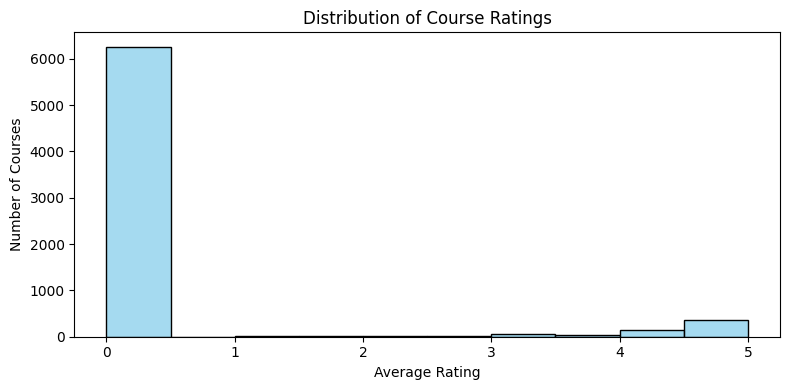

In [ ]:
# =============================
#      DISTRIBUSI RATING
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['Average Rating'], bins=10, kde=False, color='skyblue')
plt.title("Distribution of Course Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Number of Courses")
plt.tight_layout()

plt.show()


Top 10 Providers dengan Jumlah Kursus Terbanyak:
Provider
YouTube              2916
Udemy                1003
Coursera              977
edX                   695
LinkedIn Learning     239
DataCamp              231
AWS Skill Builder     124
Noble Desktop          84
freeCodeCamp           68
Udacity                65
Name: count, dtype: int64


/tmp/ipython-input-15-477953151.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




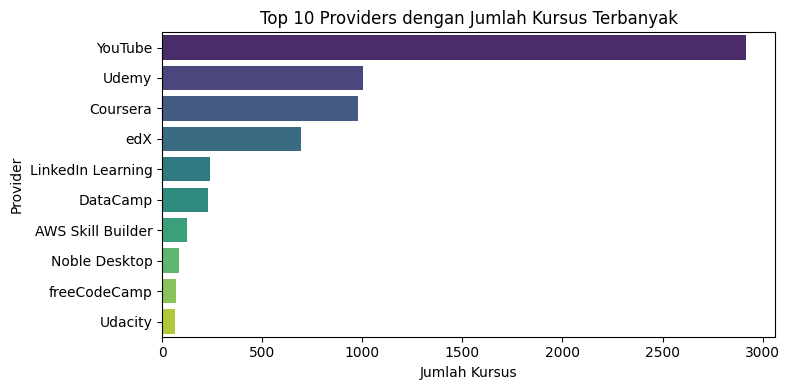

In [ ]:
# =============================
#     TOP 10 COURSE PROVIDERS
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

top_providers = df['Provider'].value_counts().nlargest(10)

print("\nTop 10 Providers dengan Jumlah Kursus Terbanyak:")
print(top_providers)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_providers.values, y=top_providers.index, palette="viridis")
plt.title("Top 10 Providers dengan Jumlah Kursus Terbanyak")
plt.xlabel("Jumlah Kursus")
plt.ylabel("Provider")
plt.tight_layout()
plt.show()

## Scraping Berhasil

Scraping telah berhasil dan sudah diambil data dari 100 halaman kursus Class Central dan menyimpannya dalam bentuk DataFrame. Data ini selajutnya akan dibersihkan dan diolah pada bagian **Text Preprocessing**.


# **2. Data Preprocessing (Text Cleaning)**

In [ ]:
# Import Library Tambahan

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download resource NLTK untuk Bahasa Inggris
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')

print("Library berhasil di-import.")

Library berhasil di-import.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Menghapus URL, Hashtag, Emoji, Angka, dan Tanda Baca
def clean_noise(text):

  # Menghapus semua tag HTML secara utuh
  text = re.sub(r'<.*?>', '', text)
  # Menghapus URL
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  # Menghapus Hashtag
  text = re.sub(r'#\w+', '', text)
  # Menghapus Emoji dan Tanda Baca
  text = re.sub(r'[^\w\s]', '', text)
  # Menghapus Angka
  text = re.sub(r'\d+', '', text)
  # Menghapus spasi berlebih
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [ ]:
# Menghapus Stopwords

# Define list_stopwords
from nltk.corpus import stopwords
list_stopwords = set(stopwords.words('english'))

def remove_stopwords(text):

  # Memecah kalimat menjadi kata-kata (tokenization)
  tokens = text.split()

  # Menghapus stopwords dari daftar token
  tokens_without_stopwords = [word for word in tokens if word not in list_stopwords]

  # Menggabungkan kembali token menjadi kalimat
  text = ' '.join(tokens_without_stopwords)
  return text

In [ ]:
# Stemming
# Membuat stemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

### **Pipeline**

In [ ]:
def cleaning_pipeline(text):
    text = clean_noise(text)

    # 1. Lowercase
    text = text.lower()

    # 2. Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in list_stopwords]

    # 5. Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # 6. Join back
    cleaned_text = ' '.join(stemmed_tokens)

    return cleaned_text

In [ ]:
# =====================
# POST-SCRAPING PIPELINE
# =====================

# Load the dataframe from the CSV file.
# This is necessary because the previous cell that scraped the data might have been re-executed
# and we want to make sure we are working with the latest scraped data.
df = pd.read_csv("/content/courses_data.csv")


if not df.empty: # Changed df_jobs to df
    print("\n✅ Scraping berhasil. Memulai pipeline post-processing...")

    # Kolom-kolom yang ingin dibersihkan
    # Ensure these columns exist in the DataFrame before trying to clean them
    text_columns = ['Title', 'Category', 'Provider', 'Language', 'Certificate', 'Price Type', 'Overview'] # Excluded 'Average Rating' and 'Reviews'


    # Bersihkan semua kolom teks
    for col in text_columns:
        if col in df.columns: # Added a check to ensure the column exists
            df[f'Cleaned {col}'] = df[col].astype(str).apply(cleaning_pipeline) # Convert to string before applying cleaning
        else:
            logging.warning(f"Column '{col}' not found in DataFrame. Skipping cleaning for this column.")


    print("\n--- CONTOH HASIL CLEANING (5 Data Pertama) ---")
    # Ensure the cleaned columns exist before trying to print them
    cleaned_columns_to_print = [f'Cleaned {col}' for col in text_columns if f'Cleaned {col}' in df.columns]
    if cleaned_columns_to_print:
        print(df[cleaned_columns_to_print].head(5))
    else:
        print("No cleaned text columns to display.")


    # Urutkan kolom biar rapi
    # Ensure all columns in final_columns exist in the DataFrame
    all_original_columns = ['Title', 'Category', 'Provider', 'Language', 'Certificate', 'Average Rating', 'Price Type', 'Reviews', 'Duration', 'Overview', 'Link']
    cleaned_columns = [f'Cleaned {col}' for col in text_columns if f'Cleaned {col}' in df.columns]
    final_columns = [col for col in all_original_columns + cleaned_columns if col in df.columns]

    df = df[final_columns]

    # Simpan ke file
    output_csv = "courses_final_data.csv"
    df.to_csv(output_csv, index=False)
    print(f"\n📁 Data berhasil disimpan ke: '{output_csv}'")

    output_json = "courses_final_data.json"
    df.to_json(output_json, orient='records', indent=4)
    print(f"📁 Data berhasil disimpan ke: '{output_json}'")

else:
    print("⚠️ Tidak ada data yang berhasil di-scrape.")


✅ Scraping berhasil. Memulai pipeline post-processing...

--- CONTOH HASIL CLEANING (5 Data Pertama) ---
                  Cleaned Title Cleaned Category Cleaned Provider  \
0  introduct data scienc python      data scienc         coursera   
1       crash cours data scienc      data scienc         coursera   
2            python data scienc      data scienc              edx   
3        data scienc math skill      data scienc         coursera   
4    program data scienc python      data scienc             udac   

  Cleaned Language Cleaned Certificate Cleaned Price Type  \
0          english        certif avail               free   
1          english        certif avail               free   
2          english              certif               free   
3          english        certif avail               free   
4          english        certif avail               paid   

                                    Cleaned Overview  
0  learn python fundament data manipul panda basi...  
1 

# Proses selesai dan data siap digunakan!

Seluruh pipeline telah berhasil dijalankan, meliputi:
1. Data Collecting: Mengambil data kursus dari situs ClassCentral dengan menggunakan Selenium.
2. Data Cleaning (Preprocessing):
    * Konversi teks menjadi lowercase
    * Penghapusan noise (URL, hashtag, angka, emoji, dan tanda baca)
    * Penghapusan stopwords
3. Data Export: Dataset yang sudah dibersihkan dan terstruktur telah disimpan dalam format CSV dan JSON.